In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.transforms as transforms
import zipfile
import io
import requests
import os
from tempfile import TemporaryDirectory


In [13]:
def plot_hist_with_ecdf(df, feature_name, *param_dicts):
    """
    Generate a histogram with an empirical cumulative distribution function overlay.

    This function is designed to handle potentially skewed data by identifying
    floor and ceiling thresholds for the displayed values.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the data to plot
    feature_name : str
        The name of the feature/column to plot
    *param_dicts : dict
        Parameter dictionaries to be passed to the plotting functions.
        The first dictionary is used for histogram parameters.
        The second dictionary is used for ECDF parameters.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object
    ax : matplotlib.axes.Axes
        The axes object
    """
    # Extract the feature data and remove NaN values
    data = df[feature_name].dropna()

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Get min and max values
    min_val = data.min()
    max_val = data.max()

    # Determine floor and ceiling thresholds (using percentiles)
    floor = data.quantile(0.01)
    ceiling = data.quantile(0.99)

    # Check if truncation is needed
    truncate_low = min_val < floor
    truncate_high = max_val > ceiling

    # Filter data based on thresholds
    filtered_data = data[(data >= floor) & (data <= ceiling)]

    # Calculate proportion of records not displayed
    prop_not_displayed = 1 - len(filtered_data) / len(data)

    # Set default histogram parameters if not provided
    hist_params = {'bins': 'sqrt', 'alpha': 0.7, 'color': 'skyblue', 'edgecolor': 'black'}
    if param_dicts and len(param_dicts) > 0:
        hist_params.update(param_dicts[0])

    # Set default ECDF parameters if not provided
    ecdf_params = {'color': 'darkblue', 'linewidth': 2}
    if param_dicts and len(param_dicts) > 1:
        ecdf_params.update(param_dicts[1])

    # Plot histogram
    hist_plot = ax.hist(filtered_data, label='Histogram', **hist_params)

    # Calculate and plot ECDF
    ecdf_x = np.sort(filtered_data)
    ecdf_y = np.arange(1, len(ecdf_x) + 1) / len(ecdf_x)

    # Create a twin axis for the ECDF
    ax2 = ax.twinx()
    ecdf_plot = ax2.plot(ecdf_x, ecdf_y, label='ECDF', **ecdf_params)
    ax2.set_ylabel('Cumulative Probability')
    ax2.set_ylim(0, 1.05)

    # Set labels and title
    ax.set_xlabel(feature_name)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {feature_name}')

    # Add text box with truncation information
    textstr = f"Empirical floor: {floor:.2f}\n"
    textstr += f"Empirical ceiling: {ceiling:.2f}\n"
    textstr += f"Proportion not displayed: {prop_not_displayed:.2%}\n"
    textstr += f"Min observed value: {min_val:.2f}\n"
    textstr += f"Max observed value: {max_val:.2f}"

    # Place the text box OUTSIDE the plotting area on the right
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    fig.text(1.05, 0.87, textstr, fontsize=10,
             verticalalignment='center', horizontalalignment='right',
             bbox=props, transform=fig.transFigure)

    # Adjust layout with padding for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend

    return fig, ax


In [3]:
# Load the IPEDS data
print("Loading IPEDS data...")

# URL of the ZIP file
zip_url = 'https://nces.ed.gov/ipeds/datacenter/data/EF2022A.zip'

# Create a temporary directory to extract files
with TemporaryDirectory() as temp_dir:
    # Download the ZIP file
    print("Downloading ZIP file...")
    response = requests.get(zip_url)
    zip_path = os.path.join(temp_dir, 'EF2022A.zip')

    # Save the ZIP file
    with open(zip_path, 'wb') as f:
        f.write(response.content)

    # Extract the ZIP file
    print("Extracting ZIP file...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # List all files in the ZIP
        file_list = zip_ref.namelist()
        print(f"Files in ZIP: {file_list}")

        # Extract all files
        zip_ref.extractall(temp_dir)

        # Choose the main CSV file (non-revised version)
        csv_file = 'ef2022a.csv'
        csv_path = os.path.join(temp_dir, csv_file)

        # Read the CSV file
        print(f"Reading CSV file: {csv_file}")
        df = pd.read_csv(csv_path, encoding="ISO-8859-1")

print(f"Dataset shape: {df.shape}")
df.head()


Loading IPEDS data...
Extracting ZIP file...
Files in ZIP: ['ef2022a.csv', 'ef2022a_rv.csv']
Reading CSV file: ef2022a.csv
Dataset shape: (116110, 73)


,UNITID,EFALEVEL,LINE,SECTION,LSTUDY,XEFTOTLT,EFTOTLT,XEFTOTLM,EFTOTLM,XEFTOTLW,...,XEFNRALW,EFNRALW,XEFGNDRU,EFGNDRUN,XEFGNDRA,EFGNDRAN,XEFGNDRU.1,EFGNDRUA,XEFGNDRK,EFGNDRKN
0,100654,1,29,3,4,R,6007,R,2369,R,...,R,44,Z,0.0,A,NaN,Z,0.0,R,6007.0
1,100654,2,99,3,1,R,5206,R,2111,R,...,R,22,R,0.0,A,NaN,R,0.0,R,5206.0
2,100654,3,99,3,1,R,5196,R,2107,R,...,R,22,A,NaN,A,NaN,A,NaN,A,NaN
3,100654,4,99,3,1,R,1557,R,622,R,...,R,2,A,NaN,A,NaN,A,NaN,A,NaN
4,100654,5,99,3,1,R,3639,R,1485,R,...,R,20,A,NaN,A,NaN,A,NaN,A,NaN


In [4]:
# Check column names to identify enrollment features
enrollment_cols = [col for col in df.columns if 'ENRL' in col or 'ENRT' in col]
if not enrollment_cols:
    # If no columns with ENRL or ENRT, look for other enrollment-related columns
    enrollment_cols = [col for col in df.columns if 'EF' in col and col.startswith('EF')]

print(f"Number of enrollment columns: {len(enrollment_cols)}")
enrollment_cols[:10]  # Display first 10 enrollment columns


Number of enrollment columns: 35


['EFALEVEL',
 'EFTOTLT',
 'EFTOTLM',
 'EFTOTLW',
 'EFAIANT',
 'EFAIANM',
 'EFAIANW',
 'EFASIAT',
 'EFASIAM',
 'EFASIAW']

Test 1: Basic usage with feature 'EFALEVEL'


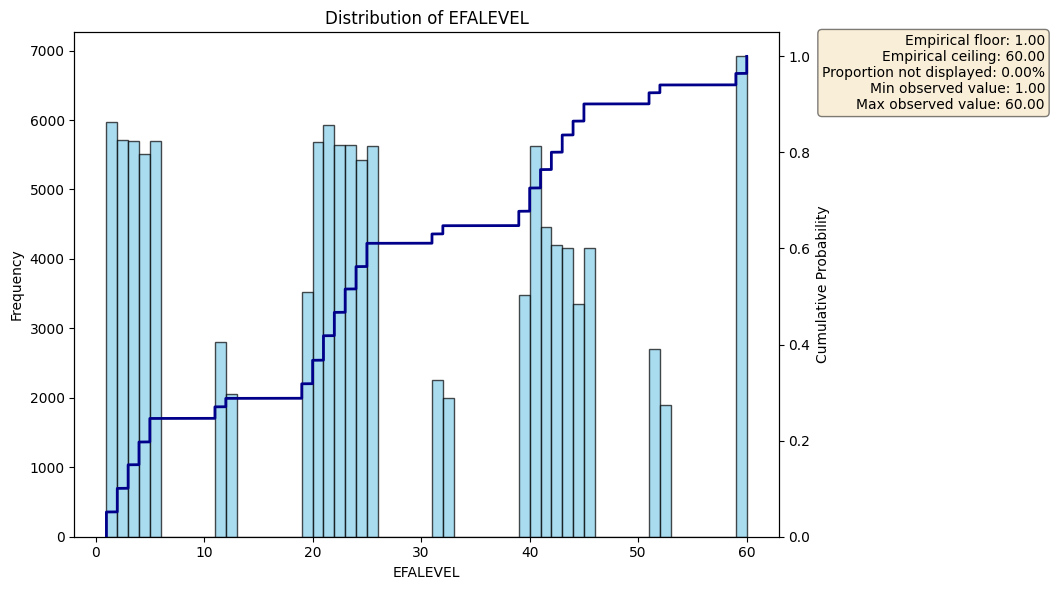

In [14]:
# Test 1: Basic usage with default parameters
feature1 = 'EFUG' if 'EFUG' in df.columns else enrollment_cols[0]
print(f"Test 1: Basic usage with feature '{feature1}'")
fig1, ax1 = plot_hist_with_ecdf(df, feature1)
plt.show()


Test 2: Custom histogram parameters with feature 'EFTOTLT'


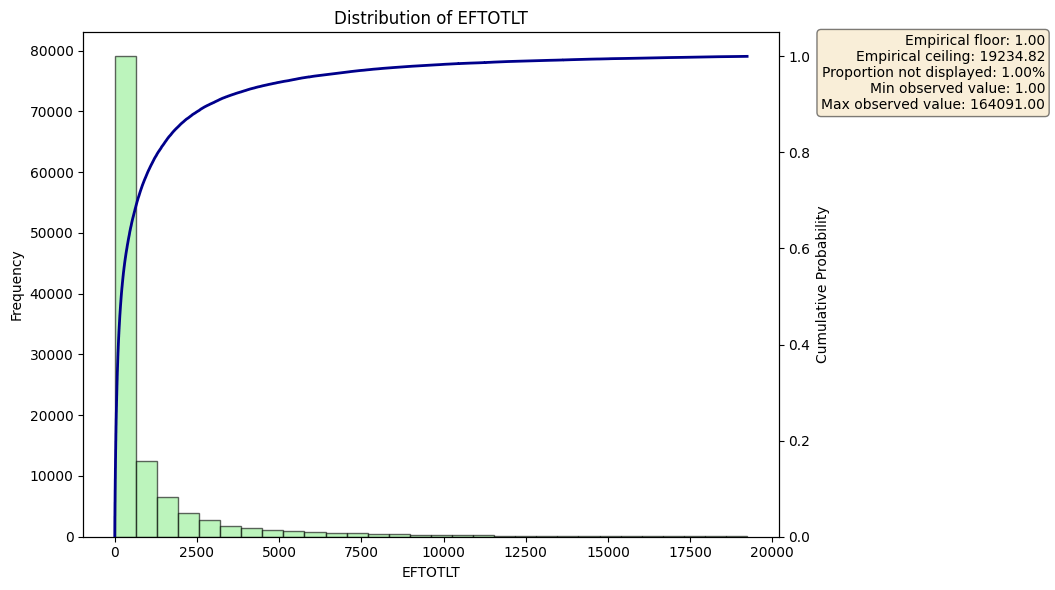

In [15]:
# Test 2: Custom histogram parameters
feature2 = 'EFGRAD' if 'EFGRAD' in df.columns else enrollment_cols[1]
print(f"Test 2: Custom histogram parameters with feature '{feature2}'")
hist_params = {'bins': 30, 'color': 'lightgreen', 'alpha': 0.6}
fig2, ax2 = plot_hist_with_ecdf(df, feature2, hist_params)
plt.show()


Test 3: Custom histogram and ECDF parameters with feature 'EFTOTLT'


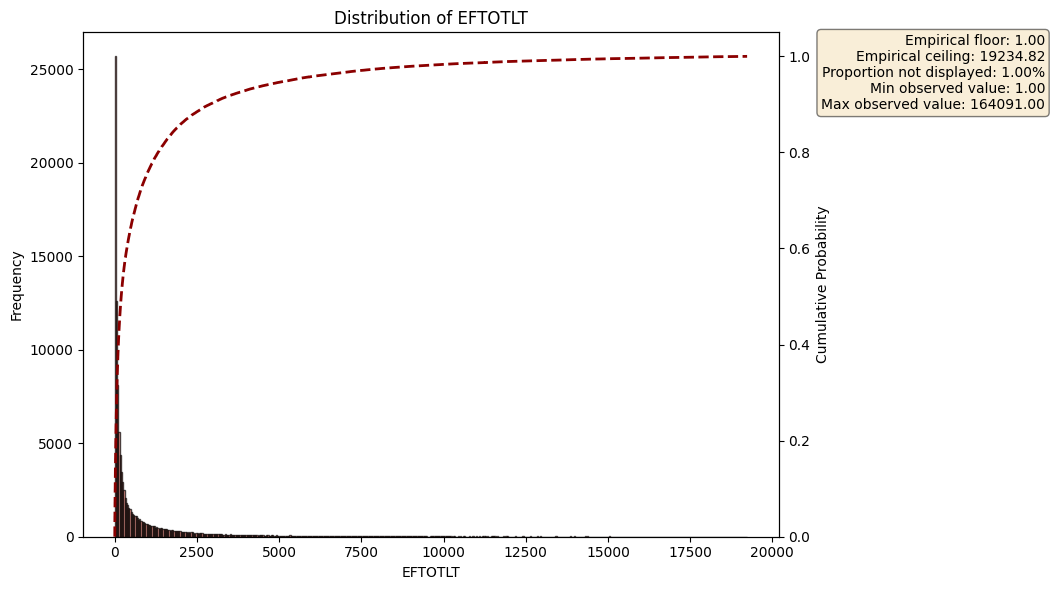

In [16]:
# Test 3: Custom histogram and ECDF parameters
feature3 = 'EFTOTLT' if 'EFTOTLT' in df.columns else enrollment_cols[2]
print(f"Test 3: Custom histogram and ECDF parameters with feature '{feature3}'")
hist_params = {'bins': 'auto', 'color': 'salmon', 'alpha': 0.7}
ecdf_params = {'color': 'darkred', 'linestyle': '--', 'linewidth': 2}
fig3, ax3 = plot_hist_with_ecdf(df, feature3, hist_params, ecdf_params)
plt.show()